<a href="https://colab.research.google.com/github/rushilg99/BayesianInference/blob/master/clusterinference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import theano.tensor as tt

In [7]:
# DATA GENERATION

# Our model won't see this
# define probability p1 of being in cluster 1, p2 of being in cluster 2, p3 = 1-p1-p2 of being in cluster 3
# suppose cluster1 ~ Normal(0,1), cluster2 ~ Normal(4,1), cluster3 ~ Normal(10,1.5)
# take p1 = 0.5, p2 = 0.2, p3 = 0.3
clusternums = np.random.choice(3,p=[0.3,0.4,0.3],size=500)
data = []
for i in clusternums:
  if i == 0:
    data.append(stats.norm.rvs(loc=0,scale=1))
  elif i == 1:
    data.append(stats.norm.rvs(loc=4,scale=1))
  else:
    data.append(stats.norm.rvs(loc=10,scale=1.5))

data = pd.Series([data])

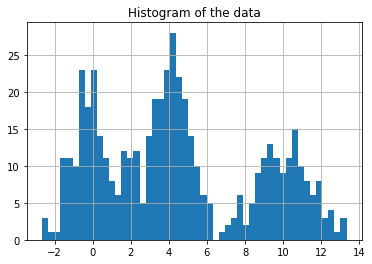

In [9]:
fig, ax = plt.subplots(nrows=1,ncols=1)
plt.title("Histogram of the data")
data.hist(bins=50, ax=ax)
plt.show()

In [10]:
# From the data, we suspect that the data is in 3 separate clusters, each of which following normal distributions centred at 0, 5 and 10 respectively
# Let's try and infer these parameters
with pm.Model() as model:
  # Model the data generation
  p1 = pm.Uniform("p1",0,0.5)
  p2 = pm.Uniform("p2",0,0.5)
  p3 = pm.Deterministic("p3",1-p1-p2)
  p = tt.stack([p1,p2,p3])
  catAssignment = pm.Categorical("catAssignment",p,shape=len(data[0]),testval=np.random.randint(0,3,size=len(data[0])))

In [11]:
with model:
  # Priors
  # Deal with the different normal distributions - want to estimate the mean and standard deviation of each - set priors
  stds = pm.Uniform("stds",0,100,shape=3)
  means = pm.Normal("means",mu=np.array([0,5,10]),sigma=np.array([10,10,10]), shape=3)

  means_i = pm.Deterministic("means_i", means[catAssignment])
  sigma_i = pm.Deterministic("sigma_i", stds[catAssignment])
  # Observed Data
  obs = pm.Normal("obs", mu=means_i,sigma=sigma_i,observed=data[0])

In [ ]:
with model:
  # Markov Chain Monte Carlo Sampling
  step1 = pm.Metropolis(vars=tt.stack([p,stds,means]))
  step2 = pm.CategoricalGibbsMetropolis(vars=[catAssignment])
  trace = pm.sample(200000, step=[step1,step2], chains=2)


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [p1]
>>Metropolis: [p2]
>>Metropolis: [stds]
>>Metropolis: [means]
>CategoricalGibbsMetropolis: [catAssignment]
100%|██████████| 200500/200500 [56:30<00:00, 59.14it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


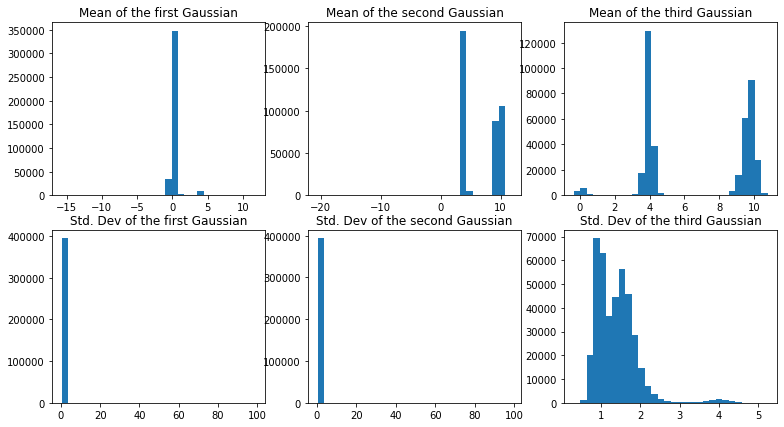

In [ ]:
%matplotlib inline
plt.figure(figsize=(13,7))
plt.subplot(231)
plt.title("Mean of the first Gaussian")
plt.hist(trace["means"][:,0],bins=30)
plt.subplot(232)
plt.title("Mean of the second Gaussian")
plt.hist(trace["means"][:,1],bins=30)
plt.subplot(233)
plt.title("Mean of the third Gaussian")
plt.hist(trace["means"][:,2],bins=30)
plt.subplot(234)
plt.title("Std. Dev of the first Gaussian")
plt.hist(trace["stds"][:,0],bins=30)
plt.subplot(235)
plt.title("Std. Dev of the second Gaussian")
plt.hist(trace["stds"][:,1],bins=30)
plt.subplot(236)
plt.title("Std. Dev of the third Gaussian")
plt.hist(trace["stds"][:,2],bins=30)
plt.show()